In [20]:
# Import necessary libraries
import pandas as pd
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
# Download AAPL stock data from 2010 to 2024
symbol = 'AAPL'
df = yf.download(symbol, start='2010-01-01', end='2024-01-01', interval='1wk')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Extract the 'Adj Close' price
df = df['Adj Close'].to_frame('price')

In [6]:
# Create a subset of data for 2023
df_2023 = df['2023-01-01':'2023-12-31'].copy()

In [7]:
# Calculate returns and create lag features
df_2023.loc[:, 'returns'] = df_2023['price'].pct_change()
df_2023.loc[:, 'lag_1'] = df_2023['price'].shift(1)
df_2023.loc[:, 'lag_2'] = df_2023['price'].shift(2)
df_2023.loc[:, 'lag_3'] = df_2023['price'].shift(3)

In [8]:
# Prepare features (X) and target (y) for the model
X = df_2023[['lag_1', 'lag_2', 'lag_3', 'returns']]
y = df_2023['price']

In [9]:
# Initialize XGBoost model and define parameter grid for hyperparameter tuning
xgb = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

In [10]:
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:

# Get the best model and print the best parameters
best_xgb = grid_search.best_estimator_
print("Best XGBoost Parameters:", grid_search.best_params_)

Best XGBoost Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100}


In [12]:
 #Generate dates for 2024 predictions
last_date = df_2023.index[-1]
dates_2024 = pd.date_range(start=last_date + timedelta(days=7), periods=52, freq='W')

In [13]:
# Prepare for 2024 predictions
xgb_pred_2024 = []
current_data = df_2023.iloc[-3:]['price'].values

In [14]:
# Make predictions for each week in 2024
for _ in range(len(dates_2024)):
    features = np.array([[current_data[-1], current_data[-2], current_data[-3], 
                          (current_data[-1] - current_data[-2]) / current_data[-2]]])
    pred = best_xgb.predict(features)[0]
    xgb_pred_2024.append(pred)
    current_data = np.roll(current_data, -1)
    current_data[-1] = pred

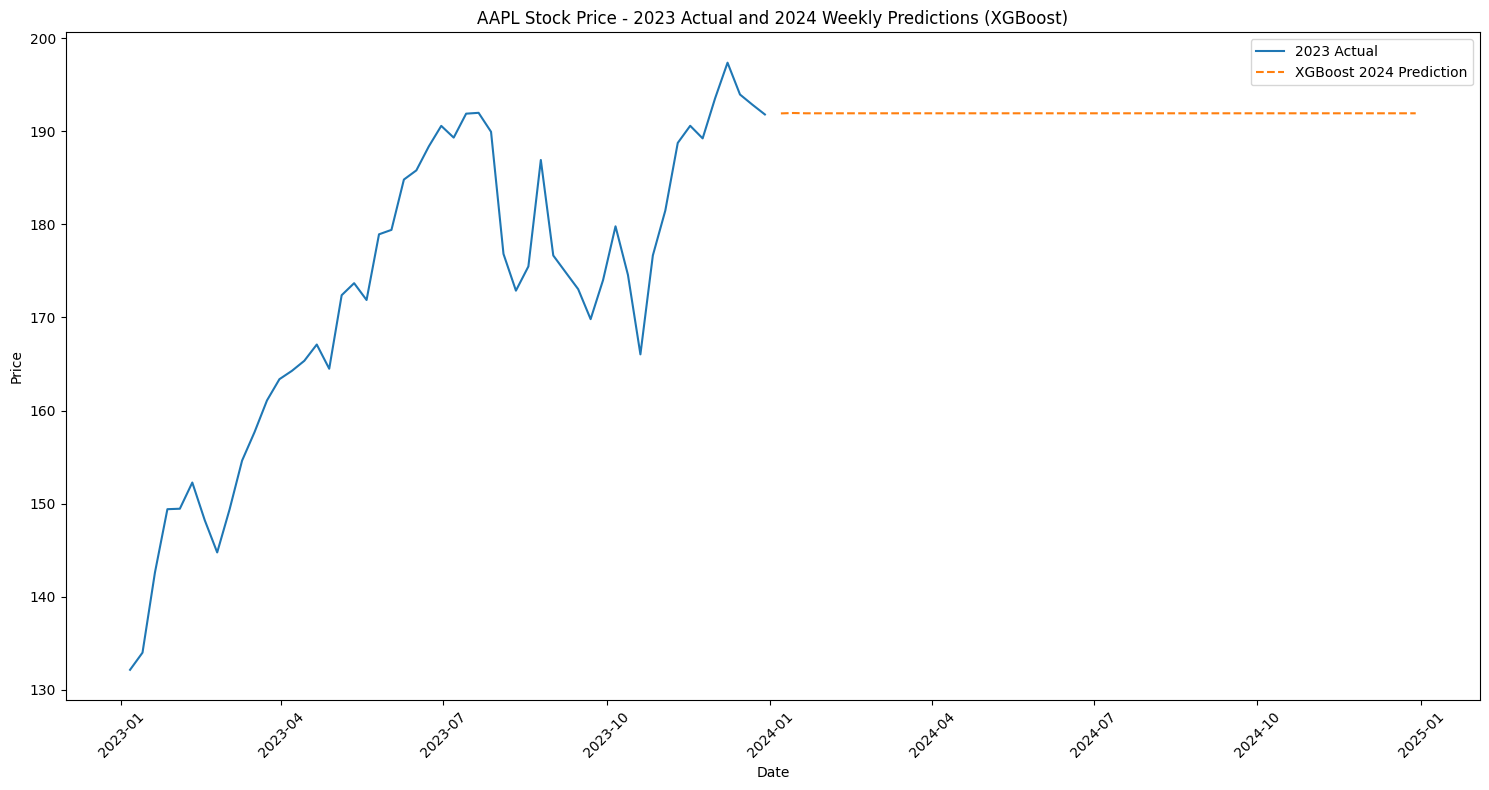

In [15]:
# Plot 2023 actual data and 2024 predictions
plt.figure(figsize=(15, 8))
plt.plot(df_2023.index, df_2023['price'], label='2023 Actual')
plt.plot(dates_2024, xgb_pred_2024, label='XGBoost 2024 Prediction', linestyle='--')
plt.title('AAPL Stock Price - 2023 Actual and 2024 Weekly Predictions (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Print summary statistics for 2024 predictions
print("\nPrediction Summary for 2024:")
print(f"XGBoost - Mean: ${np.mean(xgb_pred_2024):.2f}, Min: ${np.min(xgb_pred_2024):.2f}, Max: ${np.max(xgb_pred_2024):.2f}")


Prediction Summary for 2024:
XGBoost - Mean: $191.93, Min: $191.92, Max: $191.96


In [17]:
# Evaluate model performance on 2023 data
y_pred_2023 = best_xgb.predict(X)
mse = mean_squared_error(y, y_pred_2023)
mae = mean_absolute_error(y, y_pred_2023)
r2 = r2_score(y, y_pred_2023)

In [18]:
# Print model performance metrics
print("\nModel Performance on 2023 Data:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")


Model Performance on 2023 Data:
Mean Squared Error: 0.00
Mean Absolute Error: 0.00
R-squared Score: 1.00


In [21]:
joblib.dump(best_xgb, 'xgb_model.joblib')

['xgb_model.joblib']